In [ ]:
import os
import random
import shutil

data_dirs = ['/Users/jatin/Desktop/Winter\'23/AI/Project/Datasets/FER2013', '/Users/jatin/Desktop/Winter\'23/AI/Project/Datasets/AffectNetHQ', '/Users/jatin/Desktop/Winter\'23/AI/Project/Datasets/Tiny']

for dir_path in data_dirs:
    images = os.listdir(dir_path)
    random.shuffle(images)
    
    for num_images in [5000, 10000, 15000]:
        if num_images > len(images):
            print(f"Directory '{dir_path}' does not have enough images ({len(images)}) for {num_images} samples.")
            continue
        
        output_dir = os.path.join(dir_path, f"{num_images}_samples")
        os.makedirs(output_dir, exist_ok=True)
        
        for i in range(num_images):
            image_path = os.path.join(dir_path, images[i])
            output_path = os.path.join(output_dir, images[i])
            shutil.copy(image_path, output_path)
            
        print(f"{num_images} samples created in directory '{output_dir}'.")


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

data_dirs = ['/Users/jatin/Desktop/Winter\'23/AI/Project/Datasets/FER2013', '/Users/jatin/Desktop/Winter\'23/AI/Project/Datasets/AffectNetHQ', '/Users/jatin/Desktop/Winter\'23/AI/Project/Datasets/Tiny']

val_split = 0.16
test_split = 0.2

for data_dir in data_dirs:
    train_dir = os.path.join(data_dir, 'train')
    os.makedirs(train_dir, exist_ok=True)
    val_dir = os.path.join(data_dir, 'val')
    os.makedirs(val_dir, exist_ok=True)
    test_dir = os.path.join(data_dir, 'test')
    os.makedirs(test_dir, exist_ok=True)

    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir):
            continue

        train_images, test_val_images = train_test_split(os.listdir(class_dir), test_size=test_split+val_split)
        val_images, test_images = train_test_split(test_val_images, test_size=test_split/(test_split+val_split))

        for image_name in train_images:
            src_path = os.path.join(class_dir, image_name)
            dst_path = os.path.join(train_dir, class_name, image_name)
            os.makedirs(os.path.dirname(dst_path), exist_ok=True)
            shutil.copy(src_path, dst_path)

        for image_name in val_images:
            src_path = os.path.join(class_dir, image_name)
            dst_path = os.path.join(val_dir, class_name, image_name)
            os.makedirs(os.path.dirname(dst_path), exist_ok=True)
            shutil.copy(src_path, dst_path)

        for image_name in test_images:
            src_path = os.path.join(class_dir, image_name)
            dst_path = os.path.join(test_dir, class_name, image_name)
            os.makedirs(os.path.dirname(dst_path), exist_ok=True)
            shutil.copy(src_path, dst_path)


In [ ]:
import os
import cv2
dir_path = "/Users/jatin/Desktop/Winter'23/AI/Project/Datasets"

for subdir, _, files in os.walk(dir_path):
    for file in files:
        if file.endswith(".jpg") or file.endswith(".jpeg") or file.endswith(".png"):
            img_path = os.path.join(subdir, file)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img_resized = cv2.resize(img, (224, 224))
            img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
            cv2.imwrite(img_path, img_gray)


In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.models as models
from torchvision.transforms import ToTensor

def batch_mean_and_sd(loader):   
    
    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    for images, _ in loader:
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2,
                                  dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (
                      cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (
                            cnt + nb_pixels)
        cnt += nb_pixels

    mean, std = fst_moment, torch.sqrt(
      snd_moment - fst_moment ** 2)        
    return mean,std
  
data_dirs = ['/Users/jatin/Desktop/Winter\'23/AI/Project/Datasets/FER2013', '/Users/jatin/Desktop/Winter\'23/AI/Project/Datasets/AffectNetHQ', '/Users/jatin/Desktop/Winter\'23/AI/Project/Datasets/Tiny']

for dir_path in data_dirs:
    data = datasets.ImageFolder(root=dir_path, transform=transforms.ToTensor())
    train_loader = DataLoader(data, batch_size=32, shuffle=True)
    mean, std = batch_mean_and_sd(train_loader)
    print(f"Directory: {dir_path}, Mean: {mean}, Standard Deviation: {std}")

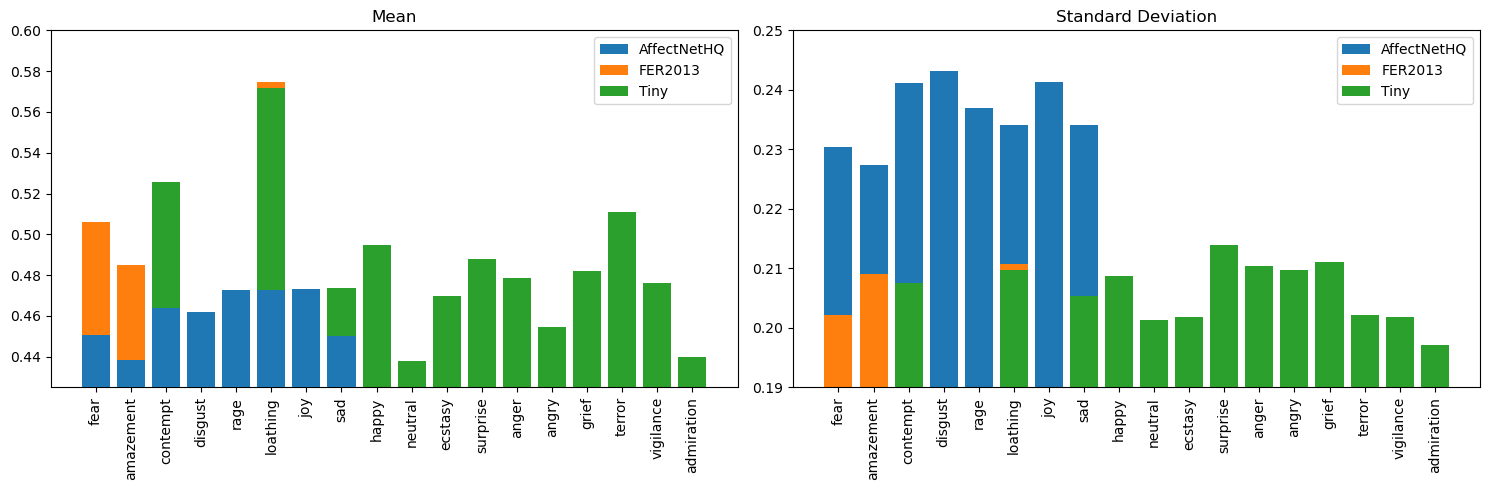

In [43]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt

# Define transforms
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])

# Load datasets
dataset1 = datasets.ImageFolder('/kaggle/input/affectnethq/AffectNetHQ/train/', transform=transform)
dataset2 = datasets.ImageFolder('/kaggle/input/fer2013/FER2013/train/', transform=transform)
dataset3 = datasets.ImageFolder('/kaggle/input/tinydataset/Tiny/train', transform=transform)

# Define dataloaders
dataloader1 = torch.utils.data.DataLoader(dataset1, batch_size=32, shuffle=True)
dataloader2 = torch.utils.data.DataLoader(dataset2, batch_size=32, shuffle=True)
dataloader3 = torch.utils.data.DataLoader(dataset3, batch_size=32, shuffle=True)

# Calculate mean and standard deviation
mean1, std1 = {}, {}
mean2, std2 = {}, {}
mean3, std3 = {}, {}
n1, n2, n3 = {}, {}, {}

for data, target in dataloader1:
    for i in range(data.size(0)):
        class_name = dataset1.classes[target[i]]
        if class_name not in mean1:
            mean1[class_name], std1[class_name] = 0., 0.
            n1[class_name] = 0
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean1[class_name] += data[i].mean()
        std1[class_name] += data[i].std()
        n1[class_name] += 1

for data, target in dataloader2:
    for i in range(data.size(0)):
        class_name = dataset2.classes[target[i]]
        if class_name not in mean2:
            mean2[class_name], std2[class_name] = 0., 0.
            n2[class_name] = 0
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean2[class_name] += data[i].mean()
        std2[class_name] += data[i].std()
        n2[class_name] += 1

for data, target in dataloader3:
    for i in range(data.size(0)):
        class_name = dataset3.classes[target[i]]
        if class_name not in mean3:
            mean3[class_name], std3[class_name] = 0., 0.
            n3[class_name] = 0
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean3[class_name] += data[i].mean()
        std3[class_name] += data[i].std()
        n3[class_name] += 1

for class_name in mean1:
    mean1[class_name] /= n1[class_name]
    std1[class_name] /= n1[class_name]

for class_name in mean2:
    mean2[class_name] /= n2[class_name]
    std2[class_name] /= n2[class_name]

for class_name in mean3:
    mean3[class_name] /= n3[class_name]
    std3[class_name] /= n3[class_name]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].bar(mean1.keys(), mean1.values(), label='AffectNetHQ',zorder=3)
axs[0].bar(mean2.keys(), mean2.values(), label='FER2013')
axs[0].bar(mean3.keys(), mean3.values(), label='Tiny', zorder=2)
axs[0].set_title('Mean')
axs[0].legend()

axs[1].bar(std1.keys(), std1.values(), label='AffectNetHQ')
axs[1].bar(std2.keys(), std2.values(), label='FER2013')
axs[1].bar(std3.keys(), std3.values(), label='Tiny', zorder=2)
axs[1].set_title('Standard Deviation')
axs[1].legend()

labels = list(set(list(mean1.keys()) + list(mean2.keys()) + list(mean3.keys())))
axs[0].set_xticks(range(len(labels)))
axs[0].set_xticklabels(labels, rotation=90)
axs[1].set_xticks(range(len(labels)))
axs[1].set_xticklabels(labels, rotation=90)
axs[0].set_ylim([0.425, 0.6])
axs[1].set_ylim([0.19, 0.25])

plt.tight_layout()
plt.show()
